In [2]:
## Imports

%matplotlib inline
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor

from uniqed.runners.tof_run import detect_outlier

from gwpy.signal import filter_design
from gwpy.timeseries import TimeSeries

from tqdm.notebook import tqdm

In [3]:
## CONSTANTS

BANDPASS = (20, 300)

DET = 'L1'

SCATTERED_LIGHT = [
    1253331031.313,
    1253362400.688,
    1245551779.625,
    1242316342.688,
    1250543149.438
]

BLIP = [
    1241313885.077,
    1241059759.294,
    1244759854.760,
    1248201703.322,
    1246580860.546
]

TOMTE = [
    1249463266.059,
    1243933155.996,
    1253921604.105,
    1244937658.590,
    1252535668.965   
]

ALL = {
    'Scattered Light': SCATTERED_LIGHT,
    'Blip': BLIP,
    'Tomte': TOMTE
}

# Definitions
## LOF stuff

In [4]:
## Animator and plotting classes

def get_rolling_windows(data, window, offset=0.5):
    data_length = data.size
    offset_idx = int(offset*window)
    if offset_idx > 0:
        data = np.insert(data, 0, np.full(offset_idx, data[0]))
    end_padding = window - offset_idx - 1
    if end_padding > 0:
        data = np.append(data, np.full(end_padding, data[-1]))
    frames = [data[i:data_length+i] for i in range(window)]
    windows = np.stack(frames, axis=-1)
    return windows


def check_time_data(times, data):
    if times.size != data.size:
        raise ValueError('times and data must be the same size')


def plot_lof_topology(times, data, lofs, axs, crit_lof=None):
    check_time_data(times, data)
    
    plots = [
        # time_series
        axs[0].plot(times, data, 'c-', zorder=1)[0],
        # lofs
        axs[1].plot(times, lofs, 'c-', zorder=1)[0]
    ]
    
    if crit_lof is not None:
        is_outlier = lofs > crit_lof
        plots.extend([
            # time_series_outliers
            axs[0].scatter(
                times[is_outlier], data[is_outlier], marker='+', facecolors='k', zorder=2),
            # lofs_outliers
            axs[1].scatter(
                times[is_outlier], lofs[is_outlier], marker='+', facecolors='k', zorder=2)
        ])
    
    return plots

def plot_lof_time_series(
    times, data, window=20,
    axs=None, xlim=None, labels=True, detections=True
):
    check_time_data(times, data)
    
    if axs is None:
        _, axs = plt.subplots(2, 1, figsize=(8,6), sharex=True)
        
    if labels:
        axs[0].set_ylabel('Time series values')
        axs[1].set_ylabel('LOF')
        axs[1].set_xlabel('Time')
    
    if xlim is not None:
        axs[1].set_xlim(*xlim)

    windows = get_rolling_windows(hdata, window)
    clf = LocalOutlierFactor()
    clf.fit_predict(windows)
    lofs = -clf.negative_outlier_factor_
    if detections:
        mean_lof = np.mean(lofs)
        lof_std = np.std(lofs)
        crit_lof = 3*lof_std + mean_lof
    else:
        crit_lof = None
    
    plot_lof_topology(times, data, lofs, axs, crit_lof)


class LOFMaxStdWindowAnimation:
    def __init__(
        self, data,
        times=None, n_range=range(4,30), n_neighbors=20,
        xlim=None, interval=500):
        
        if len(data.shape) != 1:
            raise ValueError("Input must be 1D time series")
        self.data = data
        if times is None:
            times = np.arange(0,data.size)
        self.times = times
        self.n_range = list(n_range)
        self.n_neighbors = n_neighbors
        self.fig, self.axs = plt.subplots(3, 1, figsize=(8,12))
        self.xlim = xlim
        self.anim = animation.FuncAnimation(
            self.fig, self.animate,
            init_func=self.setup_plot,
            frames=tqdm(n_range),
            interval=interval,
            blit=True
        )

    def setup_plot(self):
        blank = np.zeros(0)
        self.plots = [
            self.axs[0].plot(blank, blank)[0],
            self.axs[0].plot(blank, blank)[0],
            *plot_lof_topology(blank, blank, blank, 0, self.axs[1:])
        ]
            
        self.axs[0].set_title('Peak LOF deviation from mean per windowing size')
        self.axs[0].set_ylabel('Peak LOF deviation ($\sigma$)')
        self.axs[0].set_xlabel('Window size')
        self.axs[1].set_title('LOF Detections in Time Series')
        self.axs[1].set_ylabel('time series')
        
        if self.xlim is not None:
            self.axs[1].set_xlim(*self.xlim)
            self.axs[2].set_xlim(*self.xlim)
        
        self.axs[1].get_shared_x_axes().join(self.axs[1], self.axs[2])
        self.axs[1].set_xticklabels([])
        self.axs[2].set_xlabel('times')
        self.axs[2].set_ylabel('LOF')
        self.fig.tight_layout()
        
        self.max_lofs = []
        self.curr_range = []
        
        return self.plots

    def animate(self, n):
        windows = get_rolling_windows(self.data, n)
        clf = LocalOutlierFactor(n_neighbors=self.n_neighbors)
        clf.fit_predict(windows)
        lofs = -clf.negative_outlier_factor_
        mean_lof = np.mean(lofs)
        lof_std = np.std(lofs)
        crit_lof = 3*lof_std + mean_lof
        is_outlier = lofs > crit_lof
        
        max_dev = (np.max(lofs) - mean_lof) / lof_std
        self.max_lofs.append(max_dev)
        self.curr_range.append(n)
        new_outliers = np.stack((self.times[is_outlier], self.data[is_outlier]), axis=-1)
        new_lof_detections = np.stack((self.times[is_outlier], lofs[is_outlier]), axis=-1)
        
        # Clear previous frame
        for plot in self.plots:
            plot.remove()
        # Generate new plots
        self.plots = [
            self.axs[0].plot(self.curr_range, self.max_lofs, 'c-', zorder=1)[0],
            self.axs[0].plot(n, max_dev, 'ko', zorder=2)[0],
            *plot_lof_topology(self.times, self.data, lofs, crit_lof, self.axs[1:])
        ]
        
        return self.plots
    
    def save(self, *args, **kwargs):
        return self.anim.save(*args, **kwargs)
    
    def show(self, *args, **kwargs):
        return HTML(self.anim.to_html5_video(*args, **kwargs))

## TOF

In [5]:
def plot_tof_topology(times, res_df, axs, detections=True):
    data = res_df[0]
    check_time_data(times, res_df[0])
    tofs = res_df.TOF_score
    
    plots = [
        # time_series
        axs[0].plot(times, data, 'c-', zorder=1)[0],
        # lofs
        axs[1].plot(times, tofs, 'c-', zorder=1)[0]
    ]
    
    if detections:
        is_unicorn = (res_df.TOF == 1)
        plots.extend([
            # time_series_outliers
            axs[0].scatter(
                times[is_unicorn], data[is_unicorn], marker='+', facecolors='k', zorder=2),
            # lofs_outliers
            axs[1].scatter(
                times[is_unicorn], tofs[is_unicorn], marker='+', facecolors='k', zorder=2)
        ])
    
    return plots


def plot_tof_time_series(
    times, data, embedding_dimension=10,
    axs=None, xlim=None, labels=True, detections=True
):
    check_time_data(times, data)
    
    if axs is None:
        _, axs = plt.subplots(2, 1, figsize=(8,6), sharex=True)
        
    if labels:
        axs[0].set_ylabel('Time series values')
        axs[1].set_ylabel('TOF')
        axs[1].set_xlabel('Time')
    
    if xlim is not None:
        axs[1].set_xlim(*xlim)

    res_df = detect_outlier(
        pd.DataFrame(data)[[0]],
        cutoff_n=100,
        k=20,
        embedding_dimension=embedding_dimension
)
    
    plot_tof_topology(times, res_df, axs, detections)


class TOFEmbedDimsAnimation:
    def __init__(
        self, data,
        times=None, n_range=range(3,10), cutoff_n=100,
        xlim=None, interval=500):
        
        if len(data.shape) != 1:
            raise ValueError("Input must be 1D time series")
        self.data = data
        if times is None:
            times = np.arange(0,data.size)
        self.times = times
        self.n_range = list(n_range)
        self.cutoff_n = cutoff_n
        self.fig, self.axs = plt.subplots(2, 1, figsize=(8,6), sharex=True)
        self.xlim = xlim
        self.anim = animation.FuncAnimation(
            self.fig, self.animate,
            init_func=self.setup_plot,
            frames=tqdm(n_range),
            interval=interval,
            blit=True
        )

    def setup_plot(self):
        blank = np.zeros(0)
        self.plots = [
            self.axs[0].plot(blank, blank)[0],
            self.axs[0].plot(blank, blank)[0],
            self.axs[1].plot(blank, blank)[0],
            self.axs[1].plot(blank, blank)[0]
        ]
        
        self.axs[0].set_title(f'TOF Detections in Time Series')
        self.axs[0].set_ylabel('time series')
        self.axs[1].set_ylabel('TOF')
        self.axs[1].set_xlabel('times')
        
        if self.xlim is not None:
            self.axs[0].set_xlim(*self.xlim)
            self.axs[1].set_xlim(*self.xlim)
        
        self.fig.tight_layout(rect=[0, 0, 1, 1], pad=1, h_pad=0, w_pad=0)
        return self.plots

    def animate(self, n):
        res_df = detect_outlier(
            pd.DataFrame(self.data)[[0]], cutoff_n=self.cutoff_n, k=20, embedding_dimension=n)
        detections = res_df.TOF == 1
        tofs = res_df.TOF_score
        
        self.axs[0].set_title(f'TOF Detections in Time Series (embedding dimension {n})')
        # Clear previous frame
        for plot in self.plots:
            plot.remove()
        # Generate new plots
        self.plots = plot_tof_topology(self.times, res_df, self.axs)
        return self.plots
    
    def save(self, *args, **kwargs):
        return self.anim.save(*args, **kwargs)
    
    def show(self, *args, **kwargs):
        return HTML(self.anim.to_html5_video(*args, **kwargs))

## More graphing things

In [9]:
def reduce_to_scatter(data, dims=2, n_neighbors=20):
    output = data
    if data.shape[0] > 50:
        pca = PCA(50)
        pca.fit(data.transpose())
        output = pca.components_.transpose()
    output = TSNE(dims, perplexity=n_neighbors).fit_transform(output)
    return output


def plot_2d_scatter(data, ax, outlier_ids=None):
    scatter_data = reduce_to_scatter(data)
    ax.scatter(scatter_data[:,0], scatter_data[:,1], alpha = 0.3, s=5, facecolors='k', edgecolors='none')
    if outlier_ids is not None:
        ax.scatter(
            scatter_data[is_outlier][:,0],
            scatter_data[is_outlier][:,1],
            s = 100, facecolors='none', edgecolors='r'
        )


def overlay_on_spectrogram(times, data, ts, outseg=None, ylabel=None, plot_kwargs={}):
    spec = ts.q_transform(frange=BANDPASS, outseg=outseg).plot()
    spec.colorbar(label="Normalized energy")
    ax1 = spec.gca()
    ax2 = ax1.twinx()
    ax2.plot(times, data, **plot_kwargs)
    if outseg is not None:
        ax1.set_xlim(*outseg)
        ax2.set_xlim(*outseg)
    if ylabel is not None:
        ax2.set_ylabel(ylabel)
    spec.show()

## Data Processing

In [7]:
## Data fetching and pre-processing functions

def downsample_timeseries(data, ratio, sampler=None):
    ds = data[::ratio]
    if sampler is not None:
        data = np.append(data, np.full(data.size % ratio, data[-1]))
        bins = data.reshape(ratio, -1)
        ds = sampler(bins)
    return ds

def get_processed_event(
    detector, gps_time, length=10, offset=0, edges=1, downsample=1, sampler=None
):
    ts = get_raw_event(detector, gps_time, length, offset, edges)
    border = int(edges/ts.dt.value)
    ts = preprocess_timeseries(ts)[border:-border]
    return downsample_timeseries(ts, downsample, sampler)


def get_raw_event(detector, gps_time, length=10, offset=0, edges=1):
    bracket = edges + length/2
    t0 = gps_time - bracket + offset
    t1 = gps_time + bracket + offset
    return TimeSeries.fetch_open_data(detector, t0, t1, cache=True)
    

def preprocess_timeseries(ts, bp=BANDPASS):
    # Whiten
    ts = ts.whiten()
    # Bandpass
    ts = ts.bandpass(*bp)
    return ts

# Playground
## LOF stuff

In [ ]:
window_n = 100

# TSNE
fig2, axs2 = plt.subplots(len(ALL), 5, figsize=(40,8*len(ALL)))

for k, (name, events) in enumerate(ALL.items()):
    print(f'NOW PLOTTING {name}s')
    rows = len(events)
    
    # LOF
    fig, axs = plt.subplots(rows, 2, figsize=(8, 2*rows))
    fig.suptitle(f'{name} Events')
    fig.text(0.5, 0, 'GPS Time (s)', ha='center')
    fig.text(0, 0.5, 'Strain', va='center', rotation='vertical')
    fig.text(1, 0.5, 'LOF', va='center', rotation='vertical')
    
    # TSNE 
    row2 = axs2[k]
    row2[2].set_title(f'{name} Events')
    
    for i in tqdm(range(rows)):
        hdata = get_processed_event(DET, events[i], length=20, downsample=4)
        plot_lof_time_series(
            hdata.times.value, hdata.value, axs=axs[i], window=window_n, labels=False, detections=False)
        tsne_plot = get_rolling_windows(hdata.value, window_n)
        # plot_2d_scatter(tsne_plot, row2[i])
    fig.tight_layout()

fig2.tight_layout()

In [ ]:
hdata = get_processed_event(DET, BLIP[0], length=4, downsample=1)

fig, ax = plt.subplots(figsize=(8,8))
tsne_plot = get_rolling_windows(hdata.value, 100)
plot_2d_scatter(tsne_plot, ax)

#fn = 'data/H-H1_GWOSC_4KHZ_R1-1126257415-4.096.hdf5'
#ts = TimeSeries.read(fn,format='hdf5.losc')[::100]
#ts = ts[int(11*ts.size/22):int(13*ts.size/22)]
#ts = ts[int(ts.size/4):int(ts.size/2)]
#hdata = ts

In [ ]:
## For the whole animation

anim = LOFMaxStdWindowAnimation(
    hdata.value,
    hdata.times.value,
    xlim=(x0,x1),
    n_range=range(5,101,1),
    interval=200
)
plt.close()
anim.show()

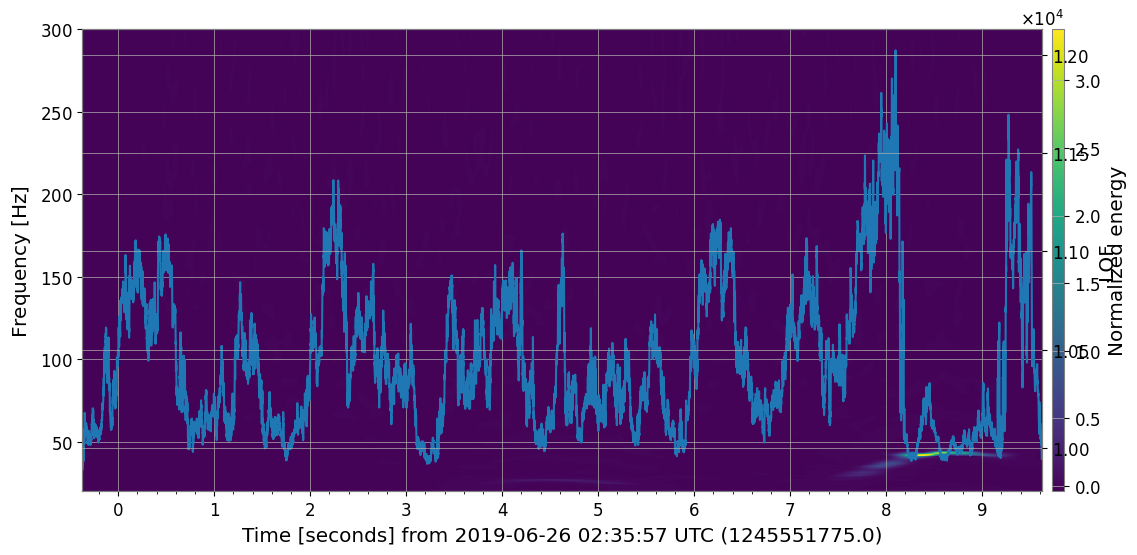

In [19]:
event = SCATTERED_LIGHT[2]
frame = 10

hdata = get_processed_event(DET, event, length=frame, downsample=1)
times = hdata.times.value
data = hdata.value
windows = get_rolling_windows(data, 1000)
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(windows)
lofs = -clf.negative_outlier_factor_

raw_data = get_raw_event(DET, event, length=frame, edges=0)
plot_kwargs = {'style': 'w-', 'alpha': 0.2}
middle = times[int(times.size/2)]
xlim = None #(middle - 0.5, middle + 0.5)
overlay_on_spectrogram(times, lofs, raw_data, outseg=xlim, ylabel='LOF')

## TOF Stuff

In [9]:
hdata = get_processed_event(DET, BLIP[0], length=4, downsample=1)
x0 = hdata.times.value[0] + 1.8
x1 = hdata.times.value[0] + 2.2

In [10]:
anim = TOFEmbedDimsAnimation(
    hdata.value,
    hdata.times.value,
    n_range=range(3,21)
)
plt.close()
anim.show()

  0%|          | 0/18 [00:00<?, ?it/s]

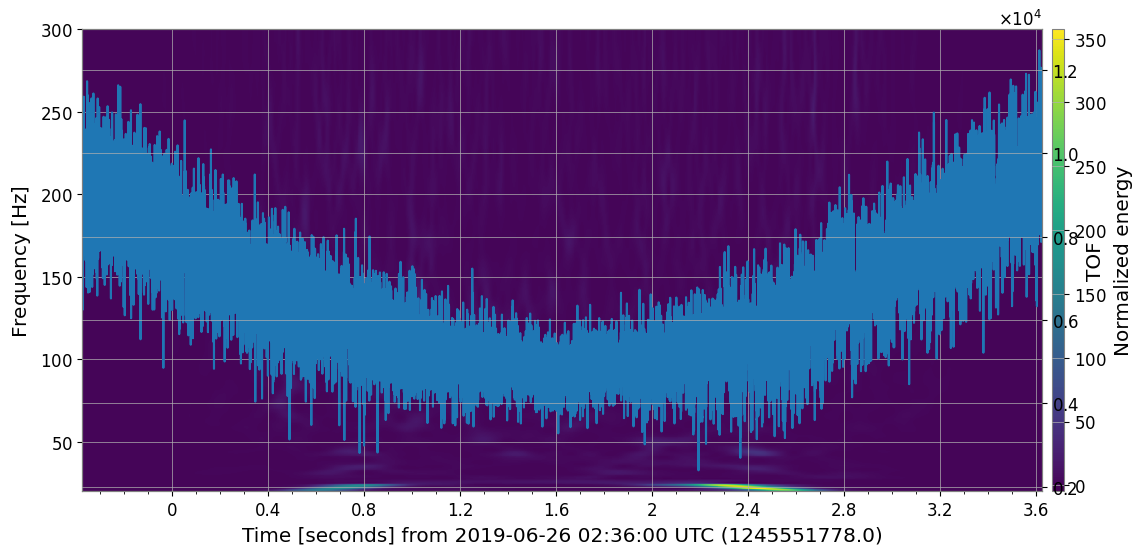

In [16]:
event = SCATTERED_LIGHT[2]
frame = 4

hdata = get_processed_event(DET, event, length=frame, downsample=1)
times = hdata.times.value
data = hdata.value
res_df = detect_outlier(
    pd.DataFrame(data)[[0]], cutoff_n=100, k=20, embedding_dimension=3)
tofs = res_df.TOF_score

raw_data = get_raw_event(DET, event, length=frame, edges=0)
plot_kwargs = {'style': 'w-', 'alpha': 0.2}
middle = times[int(times.size/2)]
xlim = None #(middle - 0.5, middle + 0.5)
overlay_on_spectrogram(times, tofs, raw_data, outseg=xlim, ylabel='TOF')